<a href="https://colab.research.google.com/github/tnwls6865/cau_deep_learning/blob/main/Huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Part 1: Hugging Face Transformers 사용을 위한 공통 패턴

우리는 Hugging Face Transformers를 사용하는 일반적인 패턴부터 시작할 것입니다. 여기서는 감정 분석(Sentiment Analysis)을 예시로 사용합니다.

### 첫 번째 단계: 허브(Hub)에서 모델 찾기
Hugging Face 허브에는 누구나 자신이 만든 모델을 업로드하고, 다른 사람들이 사용할 수 있도록 공유할 수 있습니다. (여기에서는 특정 논문에서 사용된 감정 분석 모델을 활용할 것입니다.)

### 두 번째 단계: 두 가지 객체 초기화
Hugging Face Transformers를 사용할 때 두 가지 객체를 초기화해야 합니다.

1. **Tokenizer**
   - 문자열을 모델이 필요로 하는 어휘 ID(vocabulary id) 목록으로 변환합니다.
2. **Model**
   - 어휘 ID를 받아 이를 기반으로 예측을 생성합니다.

이 두 가지 단계가 Transformers를 효과적으로 사용하는 기본적인 과정입니다.

en_chapter2_full_nlp_pipeline.svg

In [ ]:
from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import numpy as np
import torch

def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

In [ ]:
inputs = "I'm excited to learn about Hugging Face Transformers!"
tokenized_inputs = tokenizer(inputs, return_tensors="pt")
outputs = model(**tokenized_inputs)

labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)


print("Input:")
print(inputs)
print()
print("Tokenized Inputs:")
print_encoding(tokenized_inputs)
print()
print("Model Outputs:")
print(outputs)
print()
print(f"The prediction is {labels[prediction]}")

Input:
I'm excited to learn about Hugging Face Transformers!

Tokenized Inputs:
{
    input_ids:
        tensor([[    0,   100,   437,  2283,     7,  1532,    59, 30581,  3923, 12346,
         34379,   328,     2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

Model Outputs:
SequenceClassifierOutput(loss=None, logits=tensor([[-3.7605,  2.9262]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The prediction is POSITIVE


### 1.1 토크나이저(Tokenizers)

사전 학습된(Pretrained) 모델은 입력 데이터를 전처리하기 위해 사용되는 토크나이저와 함께 제공됩니다. 토크나이저는 원시 문자열(raw strings) 또는 문자열 리스트를 받아들여, 모델 입력값을 포함하는 **사전(dictionary)** 형태의 결과를 출력합니다.

#### 토크나이저에 접근하는 방법
1. **모델별 Tokenizer 클래스 사용**  
   - 사용하려는 특정 모델(예: DistilBERT)에 맞는 전용 Tokenizer 클래스를 통해 접근할 수 있습니다.

2. **AutoTokenizer 클래스 사용**  
   - AutoTokenizer를 이용하면 다양한 모델에 맞는 토크나이저를 자동으로 로드할 수 있습니다.

#### Fast Tokenizers와 Tokenizers
- **Fast Tokenizers**: Rust로 작성되어 빠른 속도를 제공합니다.  
- **Tokenizers**: Python으로 작성되어 상대적으로 느리지만, 이해하고 디버깅하기 용이합니다.

Hugging Face에서는 일반적으로 **Fast Tokenizers**를 권장합니다.

In [ ]:
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer
name = "distilbert/distilbert-base-cased"
# name = "user/name" when loading from
# name = local_path when using save_pretrained() method

tokenizer = DistilBertTokenizer.from_pretrained(name)      # written in Python
print(tokenizer)
tokenizer = DistilBertTokenizerFast.from_pretrained(name)  # written in Rust
print(tokenizer)
tokenizer = AutoTokenizer.from_pretrained(name) # convenient! Defaults to Fast
print(tokenizer)

DistilBertTokenizer(name_or_path='distilbert/distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-cased', vocab_size=28996, model_max_length=5

In [ ]:
# This is how you call the tokenizer
input_str = "HuggingFace Transformers is great!"
tokenized_inputs = tokenizer(input_str) # https://huggingface.co/learn/nlp-course/en/chapter6/6


print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

# Two ways to access:
print(tokenized_inputs.input_ids)
print(tokenized_inputs["input_ids"])

Vanilla Tokenization
{
    input_ids:
        [101, 20164, 10932, 2271, 7954, 25267, 1110, 1632, 106, 102]
    attention_mask:
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}

[101, 20164, 10932, 2271, 7954, 25267, 1110, 1632, 106, 102]
[101, 20164, 10932, 2271, 7954, 25267, 1110, 1632, 106, 102]


In [ ]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(input_str)
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print("start:                ", input_str)
print("tokenize:             ", input_tokens)
print("convert_tokens_to_ids:", input_ids)
print("add special tokens:   ", input_ids_special_tokens)
print("--------")
print("decode:               ", decoded_str)

# NOTE that these steps don't create the attention mask or add the special characters

start:                 HuggingFace Transformers is great!
tokenize:              ['Hu', '##gging', '##F', '##ace', 'Transformers', 'is', 'great', '!']
convert_tokens_to_ids: [20164, 10932, 2271, 7954, 25267, 1110, 1632, 106]
add special tokens:    [101, 20164, 10932, 2271, 7954, 25267, 1110, 1632, 106, 102]
--------
decode:                [CLS] HuggingFace Transformers is great! [SEP]


In [ ]:
# For Fast Tokenizers, there's another option too:
inputs = tokenizer._tokenizer.encode(input_str)

print(input_str)
print("-"*5)
print(f"Number of tokens: {len(inputs)}")
print(f"Ids: {inputs.ids}")
print(f"Tokens: {inputs.tokens}")
print(f"Special tokens mask: {inputs.special_tokens_mask}")
print()
print("char_to_word gives the wordpiece of a character in the input")
char_idx = 8
print(f"For example, the {char_idx + 1}th character of the string is '{input_str[char_idx]}',"+\
      f" and it's part of wordpiece {inputs.char_to_token(char_idx)}, '{inputs.tokens[inputs.char_to_token(char_idx)]}'")

HuggingFace Transformers is great!
-----
Number of tokens: 10
Ids: [101, 20164, 10932, 2271, 7954, 25267, 1110, 1632, 106, 102]
Tokens: ['[CLS]', 'Hu', '##gging', '##F', '##ace', 'Transformers', 'is', 'great', '!', '[SEP]']
Special tokens mask: [1, 0, 0, 0, 0, 0, 0, 0, 0, 1]

char_to_word gives the wordpiece of a character in the input
For example, the 9th character of the string is 'a', and it's part of wordpiece 4, '##ace'


In [ ]:
# Other cool tricks:
# The tokenizer can return pytorch tensors
model_inputs = tokenizer("Hugging Face Transformers is great!", return_tensors="pt")
print("PyTorch Tensors:")
print_encoding(model_inputs)

PyTorch Tensors:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])
}


In [ ]:
# You can pass multiple strings into the tokenizer and pad them as you need
model_inputs = tokenizer(["Hugging Face Transformers is great!",
                         "The quick brown fox jumps over the lazy dog." +\
                         "Then the dog got up and ran away because she didn't like foxes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")
print("Padding:")
print_encoding(model_inputs)

Pad token: [PAD] | Pad token id: 0
Padding:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1109,  3613,  3058, 17594, 15457,  1166,  1103, 16688,  3676,
           119,  1599,  1103,  3676,  1400,  1146,  1105,  1868,  1283,  1272,
          1131,  1238,   112,   189,  1176, 17594,  1279,   119,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])
}


In [ ]:
# You can also decode a whole batch at once:
print("Batch Decode:")
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print("Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

Batch Decode:
['[CLS] Hugging Face Transformers is great! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', "[CLS] The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn ' t like foxes. [SEP]"]

Batch Decode: (no special characters)
['Hugging Face Transformers is great!', "The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn ' t like foxes."]


### 추가 자료: 토크나이저에 대해 더 알아보기

토크나이저에 대한 더 자세한 내용을 확인하려면 아래 자료를 참고할 수 있습니다:

1. **HuggingFace Transformers 문서**  
   - HuggingFace의 Transformers 라이브러리에 포함된 토크나이저 사용법과 관련된 문서입니다.  
   - 다양한 토크나이저의 동작 방식과 사용법을 이해할 수 있습니다.
   - https://huggingface.co/docs/transformers/main_classes/tokenizer

2. **HuggingFace Tokenizers 라이브러리**  
   - 특히 **Fast Tokenizers**를 다루는 라이브러리입니다.  
   - 이 라이브러리를 사용하면 **사용자 정의 토크나이저를 직접 훈련**할 수도 있습니다!
   - https://huggingface.co/docs/tokenizers/python/latest/quicktour.html

위의 리소스들은 토크나이저의 내부 동작 방식과 응용 방법을 깊이 이해하는 데 큰 도움을 줄 것입니다.

### 1.2 모델(Models)

#### 모델 초기화
모델 초기화는 토크나이저 초기화와 매우 유사합니다. 다음 두 가지 방식 중 하나를 사용할 수 있습니다:

1. **모델별 클래스 사용**  
   - 사용하려는 특정 모델에 맞는 클래스(예: `DistilBertForSequenceClassification`)를 사용할 수 있습니다.  

2. **AutoModel 클래스 사용**  
   - `AutoModel` 클래스를 활용하면 다양한 모델을 간편하게 불러올 수 있습니다.  
   - 특히 여러 모델을 비교하거나 문자열로 모델을 지정하고자 할 때 편리합니다.

---

#### 모델 아키텍처와 "헤드"
대부분의 사전 학습된 Transformer 모델은 유사한 기본 아키텍처를 가집니다. 그러나 특정 작업(예: **문장 분류**, **질문 응답**)을 수행하려면 **"헤드(head)"라고 불리는 추가 가중치**를 훈련해야 할 수도 있습니다.

Hugging Face는 모델 클래스를 지정하면 작업에 필요한 아키텍처를 자동으로 설정해 줍니다.

##### 예시: 감정 분석
- 감정 분석을 수행할 경우, 우리는 **`DistilBertForSequenceClassification`**을 사용할 것입니다.  

##### 다른 작업을 위한 모델
- **마스킹 언어 모델링(Masked Language Modeling)**  
  - `DistilBertForMaskedLM`을 사용하여 계속 학습을 진행할 수 있습니다.  
- **모델 표현만 추출**  
  - 특정 다운스트림 작업을 위해 모델 표현만 필요하다면 `DistilBertModel`을 사용할 수 있습니다.

---

#### 시각 자료
모델의 구조를 시각적으로 이해하려면, [Hugging Face의 공식 문서](https://huggingface.co/course/chapter2/2?fw=pt)에 있는 이미지를 참고하세요. 여기에서는 모델의 기본 구조를 직관적으로 보여줍니다.

en_chapter2_transformer_and_head.svg

### 모델 예제와 종류

#### 모델 클래스 예제
Hugging Face Transformers는 작업에 따라 다양한 모델 클래스를 제공합니다. 아래는 주요 클래스의 예시입니다:

```
*Model
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```

- 여기서 `*`는 `AutoModel`이나 특정 사전 학습된 모델(예: `DistilBert`)로 대체할 수 있습니다.  

---

#### 모델의 종류
Transformer 모델은 크게 세 가지 유형으로 나뉩니다:

1. **Encoders**  
   - 입력 데이터를 인코딩하는 역할을 수행.  
   - 예: **BERT**

2. **Decoders**  
   - 텍스트 생성 작업에서 디코딩을 담당.  
   - 예: **GPT-2**

3. **Encoder-Decoder 모델**  
   - 인코더와 디코더가 결합된 구조로, 입력을 처리하고 새로운 텍스트를 생성.  
   - 예: **BART**, **T5**

---

#### 작업에 따른 모델 클래스
모델의 유형에 따라 사용 가능한 **작업별 클래스**가 다릅니다.  
예를 들어:
- `DistilBert`는 **Encoder**이므로 `Seq2Seq` 모델과 호환되지 않습니다.  
- 반면, **BART**와 **T5**는 Encoder-Decoder 구조를 갖추고 있어 번역, 요약 등의 Seq2Seq 작업에 적합합니다.

---

#### 전체 목록
사용 가능한 모델과 작업별 클래스의 전체 목록은 [Hugging Face 공식 문서](https://huggingface.co/docs/transformers/model_doc/auto)에서 확인할 수 있습니다.

> **참고**: 모든 모델이 모든 아키텍처와 호환되는 것은 아닙니다. 특정 작업에 적합한 모델을 선택하는 것이 중요합니다.

In [ ]:
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification, DistilBertModel
print('Loading base model')
base_model = DistilBertModel.from_pretrained('distilbert-base-cased')
print("Loading classification model from base model's checkpoint")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)


Loading base model
Loading classification model from base model's checkpoint


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


임의의 가중치로 초기화할 수도 있습니다.

In [ ]:
from transformers import DistilBertConfig, DistilBertModel

# Initializing a DistilBERT configuration
configuration = DistilBertConfig()
configuration.num_labels=2
# Initializing a model (with random weights) from the configuration
model = DistilBertForSequenceClassification(configuration)

# Accessing the model configuration
configuration = model.config

시퀀스 분류 매개변수가 아직 훈련되지 않았기 때문에 여기서 경고가 발생합니다.

모델에 입력을 전달하는 것은 매우 쉽습니다. 입력을 키워드 인수로 사용합니다.

In [ ]:
model_inputs = tokenizer(input_str, return_tensors="pt")

# Option 1
model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)

# Option 2 - the keys of the dictionary the tokenizer returns are the same as the keyword arguments
#            the model expects

# f({k1: v1, k2: v2}) = f(k1=v1, k2=v2)

model_outputs = model(**model_inputs)

print(model_inputs)
print()
print(model_outputs)
print()
print(f"Distribution over labels: {torch.softmax(model_outputs.logits, dim=1)}")

{'input_ids': tensor([[  101, 20164, 10932,  2271,  7954, 25267,  1110,  1632,   106,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.4427, -0.1720]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Distribution over labels: tensor([[0.6490, 0.3510]], grad_fn=<SoftmaxBackward0>)


이진 분류 작업에서 두 개의 클래스를 사용하는 것이 약간 이상하게 느껴질 수 있습니다. 단일 클래스와 임계값(threshold)을 설정하여도 작업을 수행할 수 있기 때문입니다. 이렇게 설계된 이유는 Hugging Face 모델이 **손실(loss)**을 계산하는 방식 때문입니다.

이 방식은 모델의 파라미터 수를 증가시키지만, 성능에는 영향을 미치지 않습니다.

이 모델들은 단순히 **PyTorch 모듈**입니다.
`loss_func`를 사용하여 손실을 계산하고, `loss.backward`를 호출할 수 있습니다.  
또한, 기존에 사용하던 모든 옵티마이저나 학습률 스케줄러를 그대로 사용할 수 있습니다.

In [ ]:
# You can calculate the loss like normal
label = torch.tensor([1])
loss = torch.nn.functional.cross_entropy(model_outputs.logits, label)
print(loss)
loss.backward()

# You can get the parameters
list(model.named_parameters())[0]

tensor(1.0470, grad_fn=<NllLossBackward0>)


('distilbert.embeddings.word_embeddings.weight',
 Parameter containing:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0141, -0.0356,  0.0032,  ..., -0.0246,  0.0127,  0.0088],
         [-0.0161, -0.0001, -0.0364,  ..., -0.0038, -0.0216, -0.0060],
         ...,
         [ 0.0010, -0.0129, -0.0093,  ...,  0.0164, -0.0381, -0.0009],
         [ 0.0061, -0.0004, -0.0051,  ...,  0.0027, -0.0006,  0.0306],
         [ 0.0016,  0.0175,  0.0313,  ...,  0.0060,  0.0032, -0.0279]],
        requires_grad=True))

Hugging Face는 손실(loss)을 계산하는 추가적으로 간편한 방법도 제공합니다:

In [ ]:
# To calculate the loss, we need to pass in a label:
model_inputs = tokenizer(input_str, return_tensors="pt")

labels = ['NEGATIVE', 'POSITIVE']
model_inputs['labels'] = torch.tensor([1])

model_outputs = model(**model_inputs)

print(model_outputs)
print()
print(f"Model predictions: {labels[model_outputs.logits.argmax()]}")
print(f"Loss: {model_outputs.loss}")

SequenceClassifierOutput(loss=tensor(1.0905, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.3671, -0.3139]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Model predictions: NEGATIVE
Loss: 1.0904793739318848


In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained("distilbert-base-cased", output_attentions=True, output_hidden_states=True)
model.eval()

model_inputs = tokenizer(input_str, return_tensors="pt")
with torch.no_grad():
    model_output = model(**model_inputs)


print("Hidden state size (per layer):  ", model_output.hidden_states[0].shape)
print("Attention head size (per layer):", model_output.attentions[0].shape)     # (layer, batch, query_word_idx, key_word_idxs)
                                                                               # y-axis is query, x-axis is key
# print(model_output)

Hidden state size (per layer):   torch.Size([1, 10, 768])
Attention head size (per layer): torch.Size([1, 12, 10, 10])


['[CLS]', 'Hu', '##gging', '##F', '##ace', 'Transformers', 'is', 'great', '!', '[SEP]']


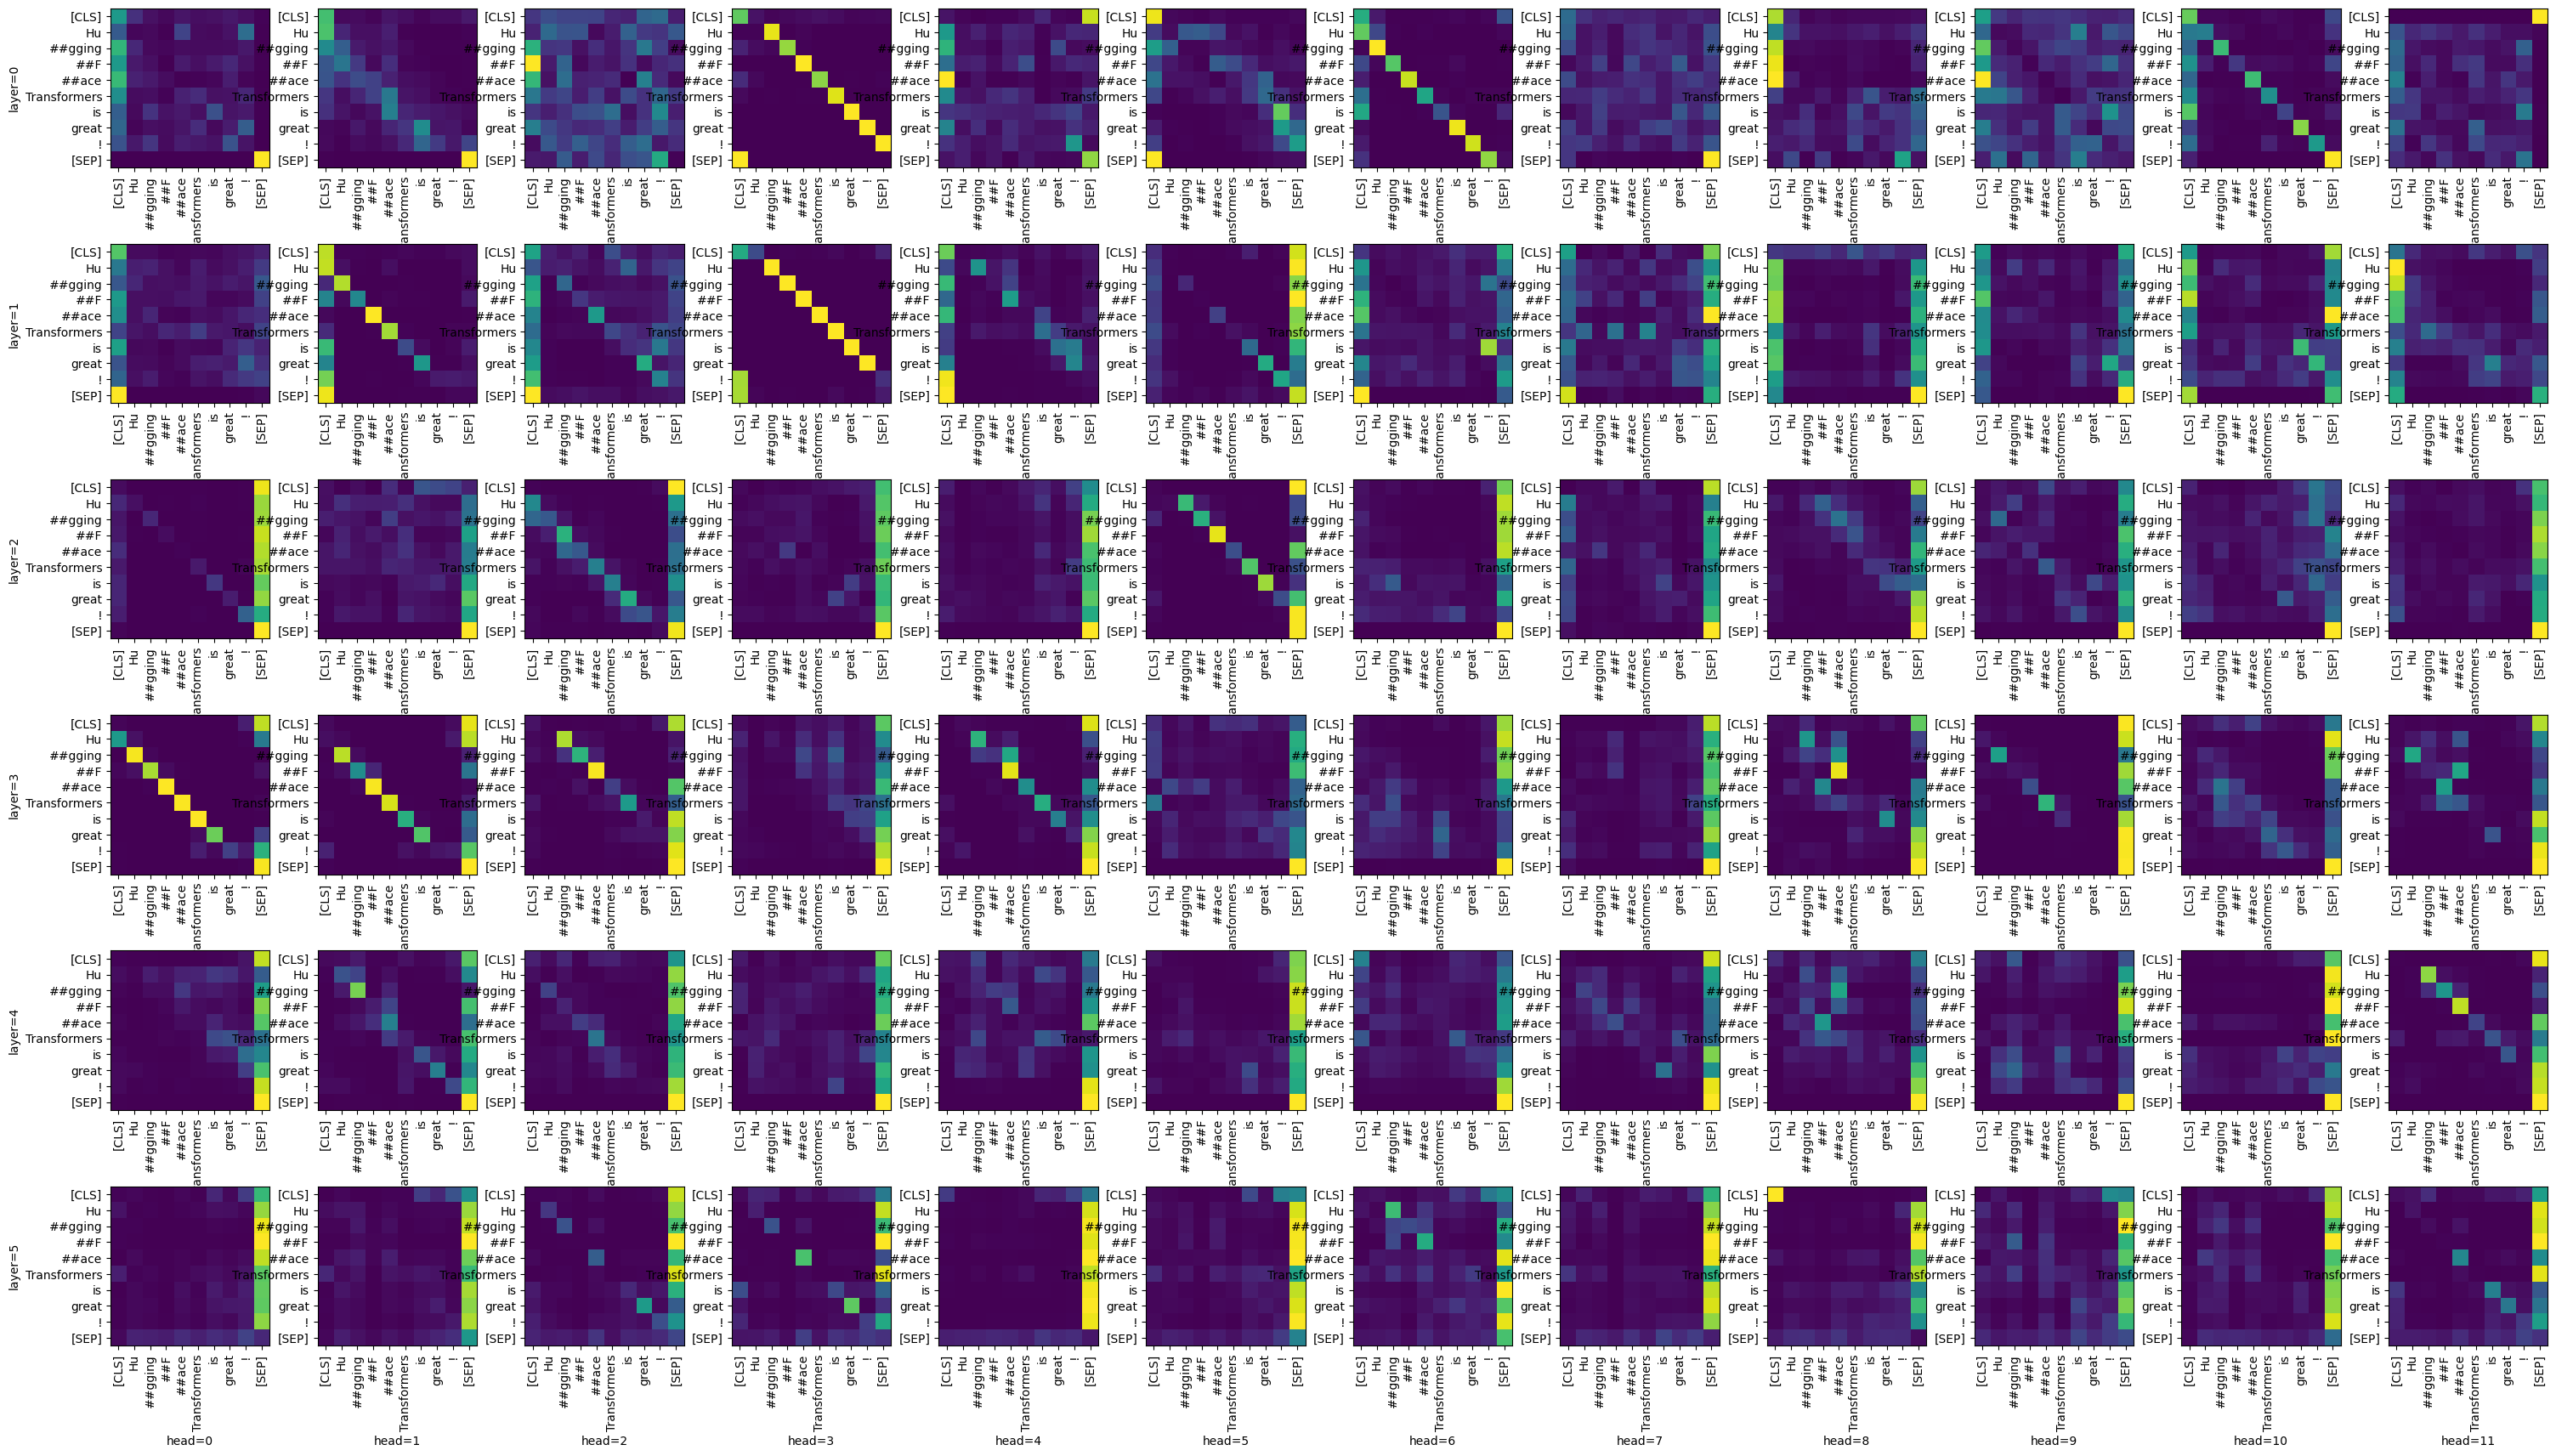

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)


n_layers = len(model_output.attentions)
n_heads = len(model_output.attentions[0][0])
fig, axes = plt.subplots(6, 12)
fig.set_size_inches(18.5*2, 10.5*2)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer, i].imshow(model_output.attentions[layer][0, i])
        axes[layer][i].set_xticks(list(range(10)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="vertical")
        axes[layer][i].set_yticks(list(range(10)))
        axes[layer][i].set_yticklabels(labels=tokens)

        if layer == 5:
            axes[layer, i].set(xlabel=f"head={i}")
        if i == 0:
            axes[layer, i].set(ylabel=f"layer={layer}")

plt.subplots_adjust(wspace=0.3)
plt.show()

## Part 2: 파인튜닝(Finetuning)

프로젝트를 진행할 때는 사전 학습된 모델(pretrained model)을 파인튜닝(finetuning)하는 경우가 훨씬 많을 것입니다.  
이 과정은 조금 더 많은 작업이 필요하지만, 여전히 비교적 간단하게 수행할 수 있습니다.

### 2.1 데이터셋 로드하기

Hugging Face 허브에는 모델뿐만 아니라 [데이터셋](https://huggingface.co/datasets)도 제공합니다.  
이곳에서 다양한 공개 데이터셋을 검색하고 쉽게 로드하여 사용할 수 있습니다.

In [ ]:
from datasets import load_dataset, DatasetDict

# DataLoader(zip(list1, list2))
dataset_name = "stanfordnlp/imdb"

imdb_dataset = load_dataset(dataset_name)

# Just take the first 50 tokens for speed/running on cpu
def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:50]),
        'label': example['label']
    }

imdb_dataset

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
# Take 128 random examples for train and 32 validation
small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)
small_imdb_dataset

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 128
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 32
    })
})

In [ ]:
small_imdb_dataset['train'][:10]

{'text': ["Probably Jackie Chan's best film in the 1980s, and the one that put him on the map. The scale of this self-directed police drama is evident from the opening and closing scenes, during which a squatters' village and shopping mall are demolished. There are, clearly, differences between the original Chinese",
  'A wonderful movie! Anyone growing up in an Italian family will definitely see themselves in these characters. A good family movie with sadness, humor, and very good acting from all. You will enjoy this movie!! We need more like it.',
  'HORRENDOUS! Avoid like the plague. I would rate this in the top 10 worst movies ever. Special effects, acting, mood, sound, etc. appear to be done by day care students...wait, I have seen programs better than this. Opens like a soft porn show with a blurred nude female doing a',
  'And I absolutely adore Isabelle Blais!!! She was so cute in this movie, and far different from her role in "Quebec-Montreal" where she was more like a man-eat

In [ ]:
# Prepare the dataset - this tokenizes the dataset in batches of 16 examples.
small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], padding=True, truncation=True), # https://huggingface.co/docs/transformers/pad_truncation
    batched=True,
    batch_size=16
)

small_tokenized_dataset = small_tokenized_dataset.remove_columns(["text"])
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")
small_tokenized_dataset.set_format("torch")

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [ ]:
small_tokenized_dataset['train'][0:2]

{'labels': tensor([1, 1]),
 'input_ids': tensor([[  101, 10109,  9662, 10185,   112,   188,  1436,  1273,  1107,  1103,
           3011,   117,  1105,  1103,  1141,  1115,  1508,  1140,  1113,  1103,
           4520,   119,  1109,  3418,  1104,  1142,  2191,   118,  2002,  2021,
           3362,  1110, 10238,  1121,  1103,  2280,  1105,  5134,  4429,   117,
           1219,  1134,   170,  4816,  6718, 18899,   112,  1491,  1105,  6001,
           8796,  1132,  6515,   119,  1247,  1132,   117,  3817,   117,  5408,
           1206,  1103,  1560,  1922,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [  101,   138,  7310,  2523,   106, 15859,  2898,  1146,  1107,  1126,
           2169,  1266,  1209,  5397,  1267,  2310,  1107,  1292,  2650,   119,
            138,  1363,  1266,  2523,  1114, 12928,   1

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_tokenized_dataset['train'], batch_size=16)
eval_dataloader = DataLoader(small_tokenized_dataset['val'], batch_size=16)

### 2.2 모델 훈련(Training)

모델을 훈련시키기 위해서는 PyTorch에서 사용하던 것과 동일한 **훈련 루프(training loop)**를 사용할 수 있습니다. Hugging Face 모델은 `torch.nn.Module`로 구현되어 있으므로, 역전파(backpropagation)도 동일하게 수행되며, 기존에 사용하던 옵티마이저를 그대로 활용할 수도 있습니다.

Hugging Face는 또한 Transformer 모델을 훈련할 때 사용되는 **옵티마이저**와 **학습률 스케줄러**를 제공하므로, 이를 활용하는 것도 가능합니다.

---

#### 기본 설정: AdamW 옵티마이저와 선형 학습률 스케줄러
- **AdamW 옵티마이저**  
  - Adam과 거의 동일하지만 **가중치 감쇠(weight decay)**를 포함합니다.  
  - 이로 인해 모델의 일반화 성능이 향상될 수 있습니다.

- **선형 학습률 스케줄러(Linear Learning Rate Scheduler)**  
  - 훈련이 진행되는 동안 각 스텝(step)마다 학습률을 조금씩 감소시킵니다.  
  - 학습 초기에는 높은 학습률을 사용하고, 후반으로 갈수록 점진적으로 낮아집니다.

---

#### 다른 옵션들
Hugging Face와 PyTorch는 다양한 옵티마이저와 학습률 스케줄러를 제공합니다. 필요에 따라 아래의 옵션을 탐색해볼 수 있습니다:

- **Hugging Face의 옵션**  
  - [Hugging Face Optimizers and Schedules](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#schedules)

- **PyTorch의 옵션**  
  - [PyTorch Optimizers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
  - 예: [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html)  
    - 검증 손실(validation loss)이 감소하지 않을 때만 학습률을 감소시킵니다.

- **사용자 정의 스케줄러 작성**  
  - 필요한 경우, 과제나 연구 목적에 맞는 커스텀 학습률 스케줄러를 구현할 수도 있습니다 (예: Assignment 4의 스케줄러).

이 기본 설정을 시작점으로 삼고, 프로젝트에 맞는 최적화 전략을 설계해보세요!

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

num_epochs = 1
num_training_steps = len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

best_val_loss = float("inf")
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    # training
    model.train()
    for batch_i, batch in enumerate(train_dataloader):

        # batch = ([text1, text2], [0, 1])

        output = model(**batch)

        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)

    # validation
    model.eval()
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            output = model(**batch)
        loss += output.loss

    avg_val_loss = loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        # torch.save({
        #     'epoch': epoch,
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'val_loss': best_val_loss,
        #     },
        #     f"checkpoints/epoch_{epoch}.pt"
        # )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 1.0406503677368164
Saving checkpoint!


In [ ]:
batch['input_ids'].max()

tensor(27013)

Hugging Face는 PyTorch를 사용하여 모델을 훈련할 수 있는 옵션을 제공하지만, 대부분의 요구를 처리할 수 있는 강력한 **`Trainer` 클래스**도 제공합니다.

이 클래스는 훈련, 평가, 그리고 예측까지의 과정을 간소화해 주며, 기본적으로 잘 작동합니다.  
다만, 특정 요구사항에 맞추기 위해 몇 가지 **커스터마이징**을 고려해볼 수도 있습니다.

`Trainer`는 다음과 같은 작업을 처리할 수 있습니다:
- 데이터셋 로드 및 배치 구성
- 옵티마이저 및 학습률 스케줄러 설정
- 모델 훈련 및 검증 루프 관리
- 로그 기록 및 체크포인트 저장

필요에 따라 `Trainer`의 기능을 확장하거나 직접 사용자 정의하여 활용할 수 있습니다.

In [ ]:
imdb_dataset = load_dataset("stanfordnlp/imdb")

small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)

small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], truncation=True),
    batched=True,
    batch_size=16
)

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

#### `TrainingArguments`와 `Trainer` 클래스

##### **`TrainingArguments`**
`TrainingArguments`는 훈련 시 설정할 다양한 매개변수를 지정합니다.  
이를 통해 아래와 같은 여러 측면을 사용자 정의할 수 있습니다:

1. **최적화 관련 설정**  
   - 학습률(learning rate)  
   - 가중치 감쇠(weight decay)  
   - 그래디언트 클리핑(gradient clipping)

2. **체크포인트와 로깅**  
   - 모델 체크포인트 저장 주기  
   - 로깅 주기 및 평가 주기

3. **로깅 위치**  
   - 기본 설정은 TensorBoard에 로그를 기록합니다.  
   - 하지만 **WandB**나 **MLFlow**와 같은 외부 툴과도 통합 가능합니다.

자세한 옵션은 [공식 문서](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)를 참고하세요.

---

##### **`Trainer`**
`Trainer`는 실제 훈련 과정을 수행하는 클래스입니다. 다음의 구성 요소들을 전달하여 사용할 수 있습니다:

- **`TrainingArguments`**: 훈련 관련 매개변수를 설정합니다.
- **모델**: 훈련시킬 모델.
- **데이터셋**: 훈련 및 평가 데이터셋.
- **토크나이저**: 데이터셋 전처리를 위한 토크나이저.
- **옵티마이저 및 스케줄러**: 옵티마이저와 학습률 스케줄러.
- **체크포인트**: 훈련 중단 지점에서 재개할 경우 체크포인트를 전달.

---

##### **`compute_metrics` 함수**
훈련 중 **평가/검증 단계**에서 호출되며, 모델의 성능 지표를 계산합니다.  
예를 들어, 정확도, 정밀도, 재현율, F1 스코어 등을 계산할 수 있습니다.

`Trainer`와 `TrainingArguments`를 활용하면 코드 작성 부담을 줄이고, 모델 훈련 과정을 효율적으로 관리할 수 있습니다.

In [ ]:
from transformers import TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

arguments = TrainingArguments(
    output_dir="sample_hf_trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    seed=224
)


def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}


trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['val'], # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-b66f733a4da7>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### **Callbacks: 로깅과 조기 종료(Early Stopping)**

Hugging Face Transformers는 훈련 중 특정 시점(예: 평가 후 또는 에포크가 끝난 후)에 실행되는 작업을 정의할 수 있는 **`Callbacks`**를 제공합니다.

##### **`Callbacks` 활용 예시**
1. **Early Stopping**  
   - 검증 손실(validation loss)이나 특정 지표(metric)가 개선되지 않을 경우, 훈련을 조기에 종료할 수 있습니다.  
   - 예: 지정된 에포크 동안 성능 개선이 없을 때 훈련 중단.

2. **Custom Logging**  
   - 훈련 진행 상황이나 평가 결과를 원하는 방식으로 기록할 수 있습니다.  
   - 예: 로그를 콘솔 출력, 파일 저장, 또는 외부 모니터링 도구(WandB 등)로 전송.

##### **사용 방법**
`Callbacks`는 `Trainer`에 추가로 전달할 수 있습니다. 이를 통해 훈련 중 특정 지점에서 동작을 정의하고 실행할 수 있습니다.

##### **추가 자료**
`Callbacks`에 대한 더 자세한 정보는 [공식 문서](https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback)를 참고하세요.

`Callbacks`는 훈련 과정을 더 세밀히 제어하거나 자동화된 로깅/관리 기능을 추가할 때 유용합니다.

In [ ]:
from transformers import TrainerCallback, EarlyStoppingCallback

class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
    # will call on_log on each logging step, specified by TrainerArguement. (i.e TrainerArguement.logginng_step)
    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")
    # def on_epoch(...)


trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0))
trainer.add_callback(LoggingCallback("sample_hf_trainer/log.jsonl"))

In [ ]:
# train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.688368,0.656250
2,No log,0.686655,0.656250


TrainOutput(global_step=16, training_loss=0.6892527341842651, metrics={'train_runtime': 73.763, 'train_samples_per_second': 3.471, 'train_steps_per_second': 0.217, 'train_loss': 0.6892527341842651, 'epoch': 2.0})

In [ ]:
# evaluating the model is very easy

# results = trainer.evaluate()                           # just gets evaluation metrics
results = trainer.predict(small_tokenized_dataset['val']) # also gives you predictions

In [ ]:
results

PredictionOutput(predictions=array([[0.07148618, 0.06527918],
       [0.11731031, 0.05425529],
       [0.12186586, 0.04846482],
       [0.09216558, 0.04456754],
       [0.04102257, 0.07276706],
       [0.05710429, 0.09280387],
       [0.11195059, 0.06914484],
       [0.10165782, 0.06887338],
       [0.06424426, 0.10245606],
       [0.0801991 , 0.05760951],
       [0.08353759, 0.06535568],
       [0.15560894, 0.0618762 ],
       [0.09017495, 0.04381759],
       [0.11936195, 0.06641212],
       [0.1211348 , 0.05131645],
       [0.12140656, 0.04682504],
       [0.14277567, 0.05011827],
       [0.05786177, 0.07232549],
       [0.07853113, 0.09204257],
       [0.05601054, 0.08179541],
       [0.13193083, 0.0581224 ],
       [0.07716011, 0.04417475],
       [0.12437437, 0.04904461],
       [0.08199598, 0.08277478],
       [0.10780726, 0.08470949],
       [0.07110046, 0.06902512],
       [0.06002688, 0.05219473],
       [0.08436812, 0.09397984],
       [0.10228436, 0.08755824],
       [0.1277

In [ ]:
# To load our saved model, we can pass the path to the checkpoint into the `from_pretrained` method:
test_str = "I enjoyed the movie!"

finetuned_model = AutoModelForSequenceClassification.from_pretrained("sample_hf_trainer/checkpoint-8")
model_inputs = tokenizer(test_str, return_tensors="pt")
prediction = torch.argmax(finetuned_model(**model_inputs).logits)
print(["NEGATIVE", "POSITIVE"][prediction])

POSITIVE


## Part 3: Generation & Pipeline

### Generation: 텍스트 생성
위의 예제에서는 분류 작업(classification task)을 위해 모델을 파인튜닝했지만, **생성 작업(generation tasks)**을 위해 모델을 파인튜닝할 수도 있습니다.  
Hugging Face에서는 **`generate` 함수**를 통해 생성 작업을 간단하게 수행할 수 있습니다.

---

#### **`generate` 함수 주요 매개변수**
1. **`max_length`**: 생성할 텍스트의 최대 길이.  
2. **`temperature`**: 샘플링 다양성을 조절. 낮을수록 결정적이고, 높을수록 랜덤성이 증가.  
3. **`num_beams`**: 빔 서치(beam search) 사용 시 빔의 개수.  
4. **`top_k`**: 샘플링 시 가장 높은 확률을 가진 상위 `k`개 토큰에서 선택.  
5. **`top_p`**: 확률 누적 값이 `p` 이하인 토큰만 샘플링에 포함하는 nucleus 샘플링.

---

`generate` 함수는 언어 생성 작업(예: 문장 생성, 요약, 번역 등)을 매우 간단하게 수행할 수 있도록 해 줍니다.  
이 함수를 사용하면 다양한 생성 모델(GPT, T5, BART 등)을 손쉽게 활용할 수 있습니다.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# 모델과 토크나이저 로드
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 입력 텍스트
input_text = "Once upon a time"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=50,  # 생성 텍스트의 최대 길이
    num_return_sequences=1,  # 생성할 텍스트 수
    temperature=0.7,  # 창의성 조절
)

# 출력 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print()
print(generated_text)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Once upon a time, the world was a place of great beauty and great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a


### Appendix 2: 파이프라인(Pipelines)

Hugging Face Transformers는 **Sentiment Classification**이나 **Question Answering** 같은 표준 NLP 작업을 쉽게 처리할 수 있는 **`Pipeline`** 인터페이스를 제공합니다.  
이 인터페이스를 통해 이미 사전 학습되고 파인튜닝된 모델들을 바로 활용할 수 있습니다.

---

#### **`Pipeline`의 특징**
- 사전 정의된 작업에 대한 간편한 사용법 제공.  
- 데이터를 전처리하고, 모델 예측을 수행하며, 결과를 후처리하는 전체 과정을 자동으로 처리.

---

#### **프로젝트에서의 활용**
직접 모델을 훈련하거나 파인튜닝할 경우에는 `Pipeline`을 자주 사용하지 않을 수도 있지만,  
**빠르게 결과를 테스트**하거나 **기본적인 프로토타입**을 만들 때 유용합니다.

---

`Pipeline`은 간단한 작업 테스트와 빠른 결과 확인을 위해 매우 유용한 도구입니다.  
더 자세한 내용은 [공식 문서](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/pipelines#transformers.pipeline)를 참고하세요!

In [ ]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
sentiment_analysis("Hugging Face Transformers is really cool!")

[{'label': 'POSITIVE', 'score': 0.998448371887207}]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english", device=device)

In [ ]:
sentiment_analysis(["I didn't know if I would like Hákarl, but it turned out pretty good.",
                    "I didn't know if I would like Hákarl, and it was just as bad as I'd heard."])

[{'label': 'POSITIVE', 'score': 0.9988769888877869},
 {'label': 'NEGATIVE', 'score': 0.9994940757751465}]

## Part 4: Masked Language Modeling

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [3]:
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")
print(f"'>>> BERT number of parameters: 110M'")

'>>> DistilBERT number of parameters: 67M'
'>>> BERT number of parameters: 110M'


In [4]:
import torch

text = "This is a great [MASK]."

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

'>>> This is a great deal.'
'>>> This is a great success.'
'>>> This is a great adventure.'
'>>> This is a great idea.'
'>>> This is a great feat.'


In [7]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")


'>>> Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...'
'>>> Label: 1'

'>>> Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stu

In [9]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 50000
    })
})

In [10]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 363'
'>>> Review 1 length: 304'
'>>> Review 2 length: 133'


In [11]:
chunk_size = 128

concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Concatenated reviews length: 800'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 32'


In [12]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [13]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 61291
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 59904
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 122957
    })
})

In [14]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [15]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] i [MASK] i am [MASK] - yellow from my video [MASK] because of all the controversy that [MASK] it [MASK] it was first released [MASK] 1967. i also heard that at [MASK] [MASK] [MASK] seized by u. [MASK] [MASK] customs if it ever tried [MASK] enter this country, [MASK] being a [MASK] of films considered " controversial " i [MASK] [MASK] transmitters see this for myself. < br / > < [MASK] / > the plot is [MASK] around a young swedish drama student named lena who wants to learn everything she [MASK] about life. in particular she¢ to [MASK] her attentions to making some [MASK] of documentary on [MASK] the average [MASK] [MASK] thought about certain political issues such'

'>>> as [MASK] vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about garage opinions on politics [MASK] she has sexjun her drama teacher, classmates [MASK] and married men. < br / > [MASK] br [MASK] > what kills me [MASK] i am curious - yellow [M

In [16]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1000
    })
})

In [17]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

<ipython-input-19-3c278844e2ec>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


>>> Perplexity: 21.94


In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,2.683400,2.496380,0.002000
2,2.583300,2.449223,0.002000
3,2.527200,2.481231,0.002000


TrainOutput(global_step=471, training_loss=2.5974472900358228, metrics={'train_runtime': 39.111, 'train_samples_per_second': 767.047, 'train_steps_per_second': 12.043, 'total_flos': 994208670720000.0, 'train_loss': 2.5974472900358228, 'epoch': 3.0})

In [22]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 12.03


In [23]:
trainer.push_to_hub()

events.out.tfevents.1733924052.30c258579303.1135.1:   0%|          | 0.00/425 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/fhzh123/distilbert-base-uncased-finetuned-imdb/commit/dc8ad654ab7b264f384a1233dc8628e21e4752f4', commit_message='End of training', commit_description='', oid='dc8ad654ab7b264f384a1233dc8628e21e4752f4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/fhzh123/distilbert-base-uncased-finetuned-imdb', endpoint='https://huggingface.co', repo_type='model', repo_id='fhzh123/distilbert-base-uncased-finetuned-imdb'), pr_revision=None, pr_num=None)

In [26]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="huggingface-course/distilbert-base-uncased-finetuned-imdb"
)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [27]:
preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['sequence']}")

>>> this is a great film.
>>> this is a great movie.
>>> this is a great idea.
>>> this is a great deal.
>>> this is a great adventure.
